# Noise filter

In [1]:
import sdm as sdmlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import urllib, cStringIO
import random
from IPython.core.display import display, Image as IPythonImage
%matplotlib inline

In [2]:
width = 30
height = 30
noise_flip = True

In [3]:
def gen_img(letter='A'):
    img = Image.new('RGBA', (30, 30), (255, 255, 255))
    font = ImageFont.truetype('Arial.ttf', 30)
    draw = ImageDraw.Draw(img)
    draw.text((5, 0), letter, (0, 0, 0), font=font)
    return img

In [4]:
def gen_noise_add(img, p=0.15, flip=False):
    img2 = img.copy()
    draw = ImageDraw.Draw(img2)
    for py in xrange(height):
        for px in xrange(width):
            if random.random() < p:
                if flip:
                    pixel = img.getpixel((px, py))
                    value = sum([int(x/255+0.5) for x in pixel[:3]])//3
                    assert value == 0 or value == 1
                    value = (1 - value)*255
                    draw.point((px, py), fill=(value, value, value))
                else:
                    draw.point((px, py), fill=(0, 0, 0))
    return img2

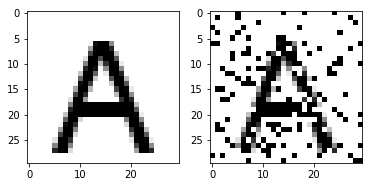

In [5]:
img = gen_img();
img2 = gen_noise_add(img, flip=noise_flip)
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(img2);

In [6]:
def to_bitstring(img):
    v = []
    bs = sdmlib.Bitstring.init_ones(1000)
    for py in xrange(height):
        for px in xrange(width):
            pixel = img.getpixel((px, py))
            value = sum([int(x/255+0.5) for x in pixel[:3]])//3
            assert value == 0 or value == 1
            idx = px+width*py
            assert idx >= 0 and idx < 1000, 'Ops {} {} {}'.format(x, y, idx)
            bs.set_bit(idx, value)
            v.append(value)
    v2 = [bs.get_bit(i) for i in xrange(height*width)]
    assert v == v2
    return bs

In [7]:
def to_img(bs):
    img = Image.new('RGBA', (30, 30), (255, 255, 255))
    draw = ImageDraw.Draw(img)
    for py in xrange(height):
        for px in xrange(width):
            idx = px+width*py
            assert idx >= 0 and idx < 1000, 'Ops {} {} {}'.format(x, y, idx)
            x = 255*bs.get_bit(idx)
            draw.point((px, py), fill=(x, x, x))
    return img

In [8]:
bits = 1000
sample = 1000000
scanner_type = sdmlib.SDM_SCANNER_OPENCL

In [9]:
address_space = sdmlib.AddressSpace.init_from_b64_file('sdm-letters.as')
counter = sdmlib.Counter.load_file('sdm-letters')
sdm = sdmlib.SDM(address_space, counter, 451, scanner_type)

In [32]:
def read(letter, n=6, p=0.25):
    n = 20
    cols = 7
    rows = n//cols + 1
    plt.figure(figsize=(20,10))

    img = gen_img(letter=letter);
    img2 = gen_noise_add(img, p=p, flip=noise_flip)
    plt.subplot(rows, cols, 1)
    plt.imshow(img2)

    for i in xrange(n):
        bs2 = to_bitstring(img2)
        bs3 = sdm.read(bs2)
        if bs3 == bs2:
            break
        img3 = to_img(bs3)
        plt.subplot(rows, cols, i+2)
        plt.imshow(img3)
        img2 = img3

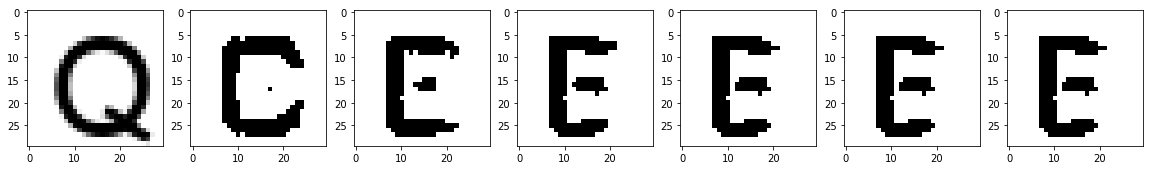

In [35]:
read('Q', p=0)